In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import time

import parser
import xml.etree.ElementTree as et
import pandas_profiling
import clean_data

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

### Parse training and validation sets and save files

In [2]:
# read train set
a = time.time()
data_dir = '../training'
frames = []
num_files = 0
for filename in os.listdir(data_dir):
    xtree = et.parse(os.path.join(data_dir, filename))
    myroot = xtree.getroot()
    file_data = parser.parse(myroot, 'train')
    file_data = parser.create_cols(file_data, 'train')
    file_data = parser.create_dataframe(file_data, 'train')
    frames.append(file_data)
    
    num_files +=1
    
raw_data = pd.concat(frames)
b = time.time()
print('Time to parse train files: {}, Number of frames: {}.'.format(b - a, num_files))


# read validation set
a = time.time()
data_dir = '../validation'
frames = []
num_files = 0
for filename in os.listdir(data_dir):
    xtree = et.parse(os.path.join(data_dir, filename))
    myroot = xtree.getroot()
    file_data = parser.parse(myroot, 'validation')
    file_data = parser.create_cols(file_data, 'validation')
    file_data = parser.create_dataframe(file_data, 'validation')
    frames.append(file_data)
    
    num_files +=1
#     print(num_files)
raw_validation = pd.concat(frames)
b = time.time()
print('Time to parse validation files: {}, Number of frames: {}.'.format(b - a, num_files))

data_dir = '../data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# raw_data.to_csv(os.path.join(data_dir, '00_raw_data.csv'))
# raw_validation.to_csv(os.path.join(data_dir, '00_raw_val_data.csv'))

Time to parse train files: 37.30248785018921, Number of frames: 7998.
Time to parse validation files: 9.278516054153442, Number of frames: 1999.


### View Distributions

In [3]:
last_activity = raw_data['last_activity'].values
month_payment = raw_data['month_payment'].values
# emp_normalized = emp[np.argwhere(emp)]

score = raw_data['score'].values
score_normalized = score[np.argwhere(score)]

high_credit = raw_data['high_credit'].dropna().values
high_credit_normalized = high_credit[np.argwhere(high_credit)]

balance = raw_data['balance'].dropna().values
balance_normalized = balance[np.argwhere(balance)]

overdue = raw_data['overdue'].dropna().values
overdue_normalized = overdue[np.argwhere(overdue)]


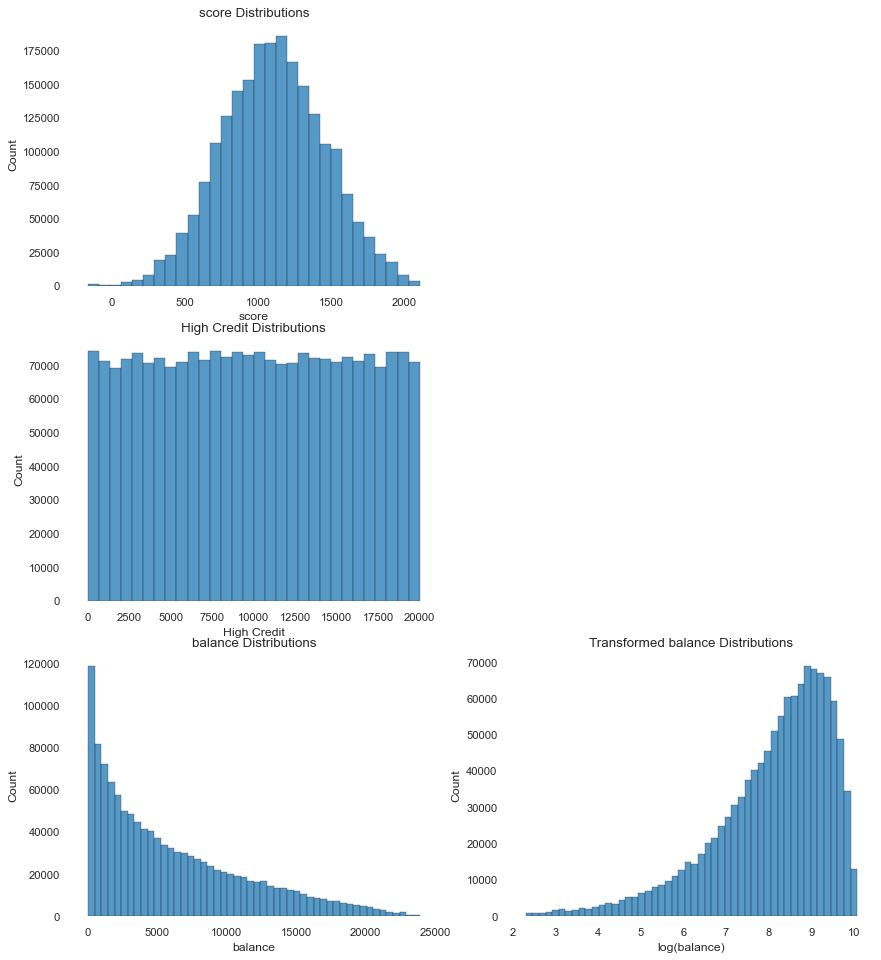

In [4]:
gs = gridspec.GridSpec(4, 3)
plt.figure(figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')


#score
ax = plt.subplot(gs[0, 0])
ax.hist(score, bins = 30, edgecolor = 'black', alpha = 0.75, align='mid')
ax.set_xlabel('score')
ax.set_ylabel('Count')
# ax.set_xlim([0, 5e5])
ax.set_title('score Distributions')

# ax1 = plt.subplot(gs[0, 1])
# ax1.hist(np.log(score_normalized), bins = 30, edgecolor = 'black', alpha = 0.75, align='mid')
# ax1.set_xlabel('log(score)')
# ax1.set_ylabel('Count')
# ax1.set_title('Transformed score Distributions')


# high credit
ax2 = plt.subplot(gs[1, 0])
ax2.hist(high_credit, bins = 30, edgecolor = 'black', alpha = 0.75, align='mid')
ax2.set_xlabel('High Credit')
ax2.set_ylabel('Count')
# ax2.set_xlim([0, 1e12])
ax2.set_title('High Credit Distributions')

# ax3 = plt.subplot(gs[1, 1])
# ax3.hist(np.log(high_credit_normalized), bins = 30, edgecolor = 'black', alpha = 0.75, align='mid')
# ax3.set_xlabel('log(High Credit)')
# ax3.set_ylabel('Count')
# ax3.set_title('Transformed High Credit (converted) Distributions')


# balance
ax4 = plt.subplot(gs[2, 0])
ax4.hist(balance_normalized, bins = 50, edgecolor = 'black', alpha = 0.75, align='mid')
ax4.set_xlabel('balance')
ax4.set_ylabel('Count')
ax4.set_title('balance Distributions')

ax5 = plt.subplot(gs[2, 1])
ax5.hist(np.log(balance_normalized), bins = 50, edgecolor = 'black', alpha = 0.75, align='mid')
ax5.set_xlabel('log(balance)')
ax5.set_ylabel('Count')
ax5.set_title('Transformed balance Distributions')



plt.show()

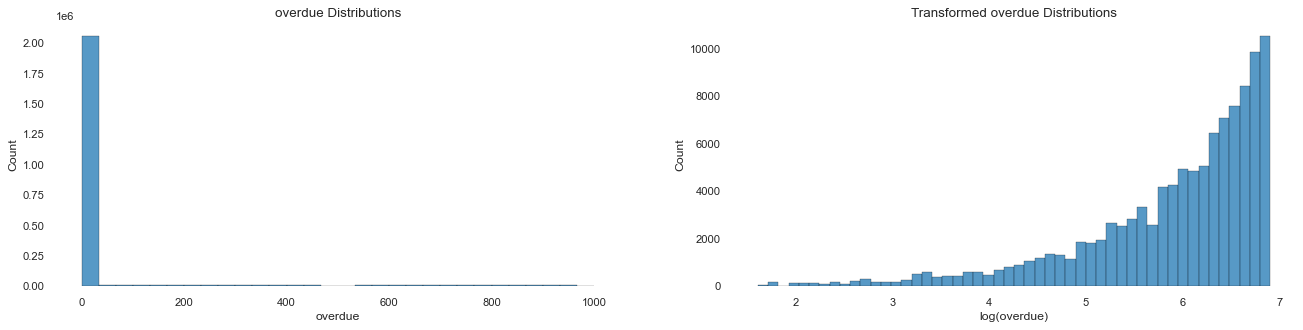

In [5]:
gs = gridspec.GridSpec(4, 2)

plt.figure(figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
# overdue
ax6 = plt.subplot(gs[2, 0])
ax6.hist(overdue, bins = 30, edgecolor = 'black', alpha = 0.75, align='mid')
ax6.set_xlabel('overdue')
ax6.set_ylabel('Count')
ax6.set_title('overdue Distributions')

ax7 = plt.subplot(gs[2, 1])
ax7.hist(np.log(overdue_normalized), bins = 50, edgecolor = 'black', alpha = 0.75, align='mid')
ax7.set_xlabel('log(overdue)')
ax7.set_ylabel('Count')
ax7.set_title('Transformed overdue Distributions')
# plt.savefig('Transformed Features.pdf')

plt.show()

### Box Plot

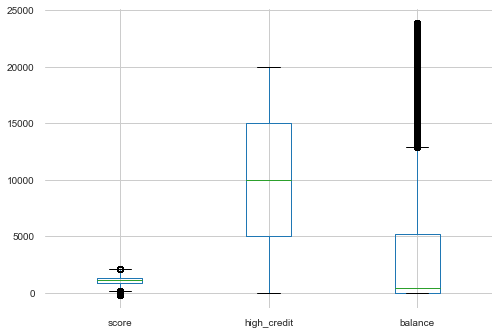

In [6]:
raw_data[['score', 'high_credit', 'balance']].boxplot()

### Pearson's r coorelation coeffecient

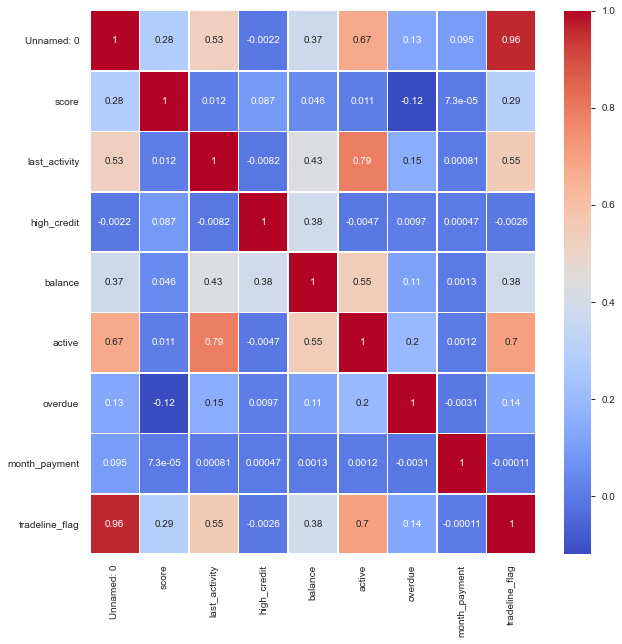

In [7]:
import seaborn as sns
plt.figure(figsize=(10,10)) #sets the size of the table so all values can be displayed clearly
sns.heatmap(raw_data.corr(), annot = True, cmap="coolwarm", linewidth=0.5) #shows a heatmap of the coorelation dataframe with the values and a "coolwarm" mapping and a legend on the right
plt.show()

### Time Series

In [8]:
ordered = clean_data.add_3_features(raw_data)
# appending yr_month_payment additional feature
last_activity = ordered['last_activity'].apply(lambda x: str(x))
month_payment = ordered['month_payment'].apply(lambda x: str(x) if x > 9 else '0' + str(x))
last_activity = [x + '-' + y for x, y in zip(last_activity, month_payment)]
ordered['yr_month_payment'] = pd.Series(last_activity)

# choosing ids for low, med, high
print(ordered[ordered['avg_high_credit'] <= 5000].shape)  #low
print(ordered[(ordered['avg_high_credit'] > 8000) & (ordered['avg_high_credit'] <= 12000)].shape) # med
print(ordered[ordered['avg_high_credit'] > 17000].shape) # high

(8217, 22)
(1565586, 22)
(168, 22)


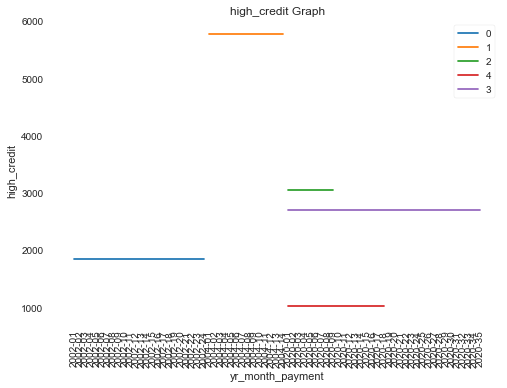

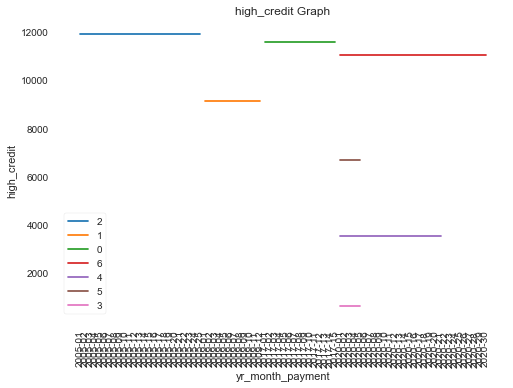

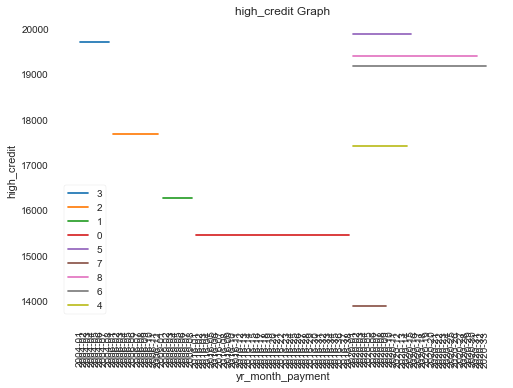

In [9]:
# low, med, high dataframes
low = ordered[ordered['ID'] == '7ad38723-6cf6-49a8-88ae-e3c09ce1bd4d']
med = ordered[ordered['ID'] == 'fbbfd912-cd67-4f18-b961-fad31c6261da']
high = ordered[ordered['ID'] == '61b35123-ce09-497f-8b3a-8ad0f26875c0']

# sorted by tradeline_flag and yr_month_payment
low_sorted_tradeline = clean_data.sort_by_yr_month_payment_tradeline_flag(low)
med_sorted_tradeline = clean_data.sort_by_yr_month_payment_tradeline_flag(med)
high_sorted_tradeline = clean_data.sort_by_yr_month_payment_tradeline_flag(high)

# sorted by yr_month_payment only
low_sorted = clean_data.sort_by_yr_month_payment_only(low)
med_sorted = clean_data.sort_by_yr_month_payment_only(med)
high_sorted = clean_data.sort_by_yr_month_payment_only(high)

clean_data.plot_tradelines(low_sorted, 'low')
clean_data.plot_tradelines(med_sorted, 'med')
clean_data.plot_tradelines(high_sorted, 'high')

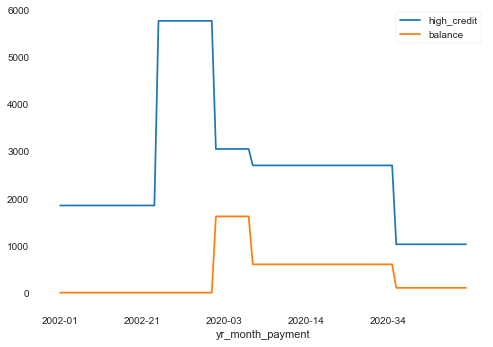

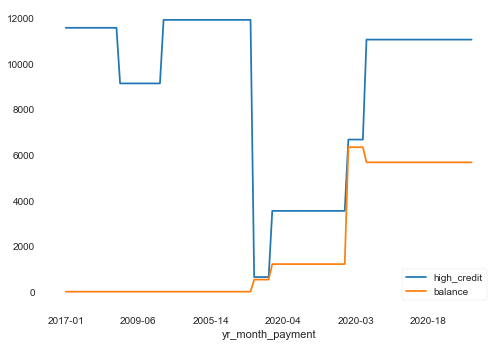

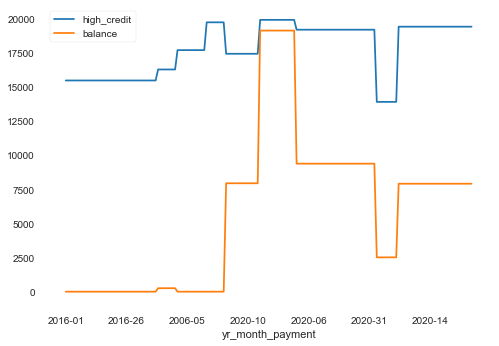

In [10]:
# sorted by yr_month AND FLAG
low_sorted_tradeline.plot(x = 'yr_month_payment', y=['high_credit', 'balance'])
med_sorted_tradeline.plot(x = 'yr_month_payment', y=['high_credit', 'balance'])
high_sorted_tradeline.plot(x = 'yr_month_payment', y=['high_credit', 'balance'])

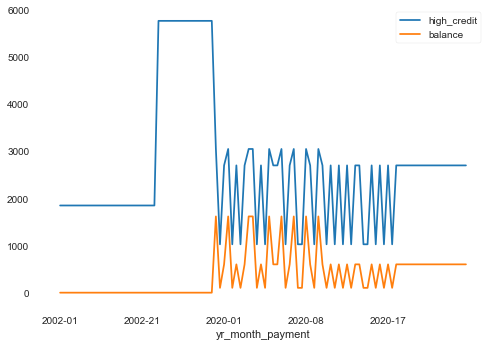

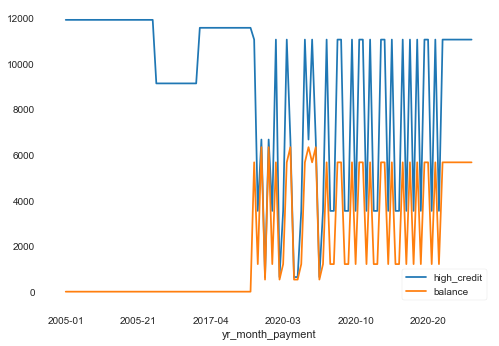

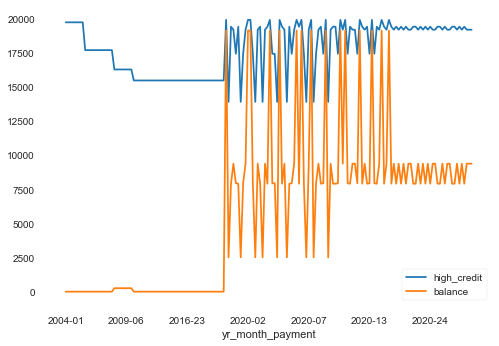

In [11]:
# sorted by yr_month only
low_sorted.plot(x = 'yr_month_payment', y=['high_credit', 'balance'])
med_sorted.plot(x = 'yr_month_payment', y=['high_credit', 'balance'])
high_sorted.plot(x = 'yr_month_payment', y=['high_credit', 'balance'])

### PCA and KMeans

In [12]:
# randomly select indices from file because there are too many datapoints to plot otherwise
# delete this line
raw_data.drop(columns = {'Unnamed: 0'}, inplace = True)
df1 = raw_data.drop(columns = {'ID', 'first_name', 'last_name', 'SSN', 'address'})
indices = 40000
df = clean_data.select_subset(df1, indices)
prepro_in = clean_data.PreprocessBaseline(df)
df, _ = prepro_in()
df.drop(columns = {'score', 'last_activity', 'month_payment'}, inplace = True)
X = np.array(df)

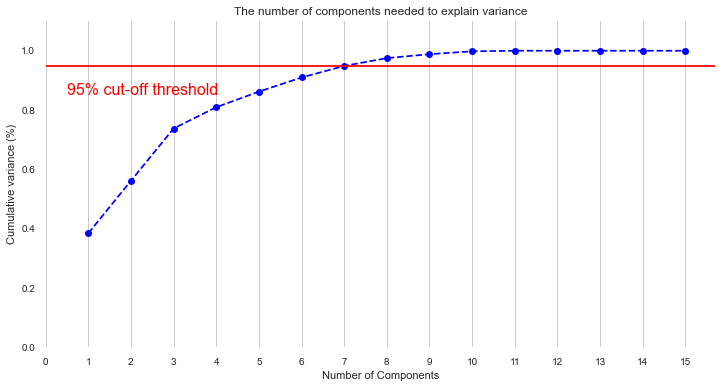

In [13]:
# obtain 95% variance, need to decompose to 7 features
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(X)


pca = PCA(n_components = 0.95)
pca.fit(data_rescaled)
reduced = pca.transform(data_rescaled)


pca = PCA().fit(data_rescaled)
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 16, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 16, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [14]:
components = 7
pca = PCA(n_components=components)
pca_x = pca.fit_transform(X)

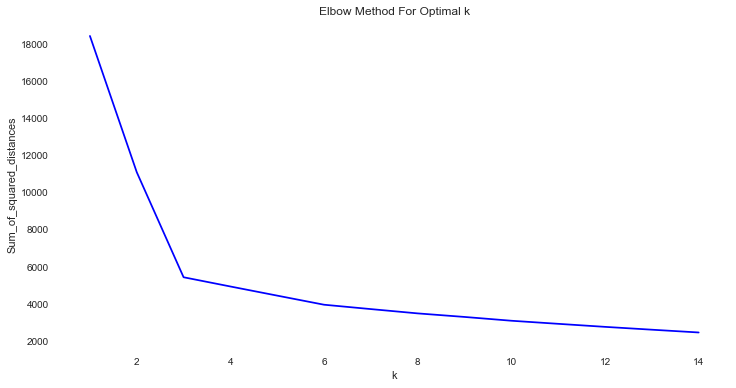

In [15]:
mms = MinMaxScaler()
mms.fit(pca_x)
data_transformed = mms.transform(pca_x)

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

0 1


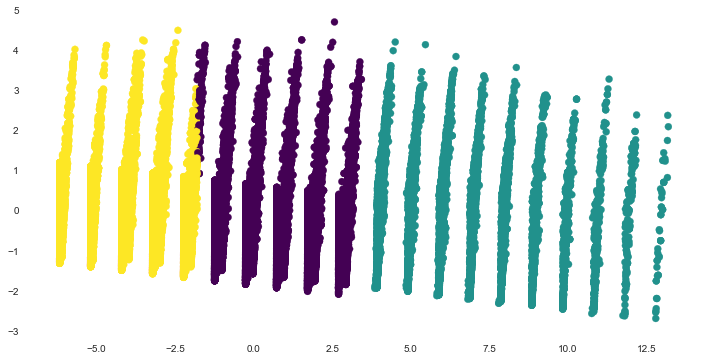

0 2


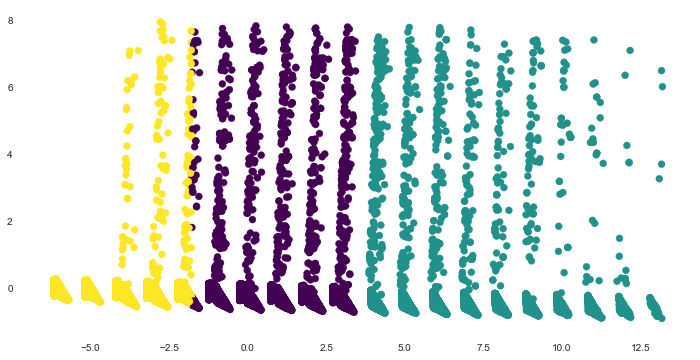

0 3


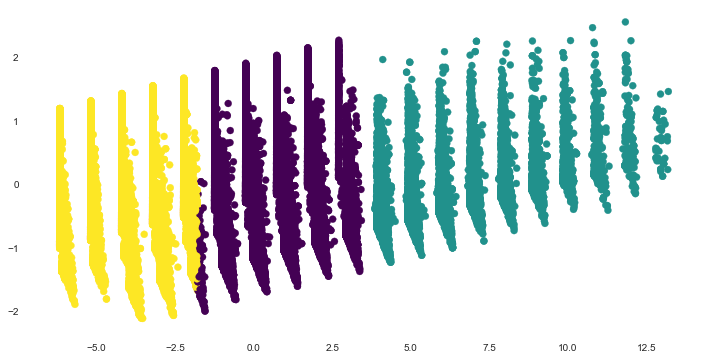

0 4


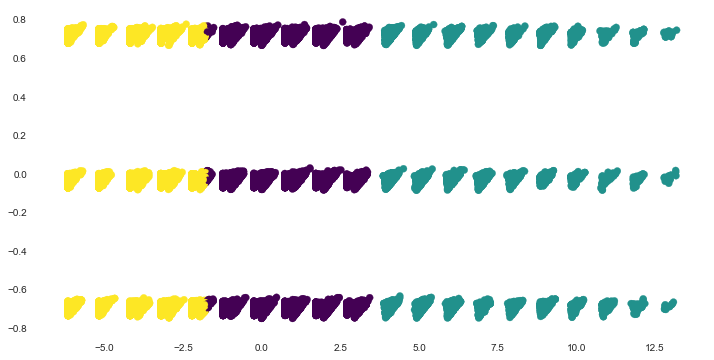

0 5


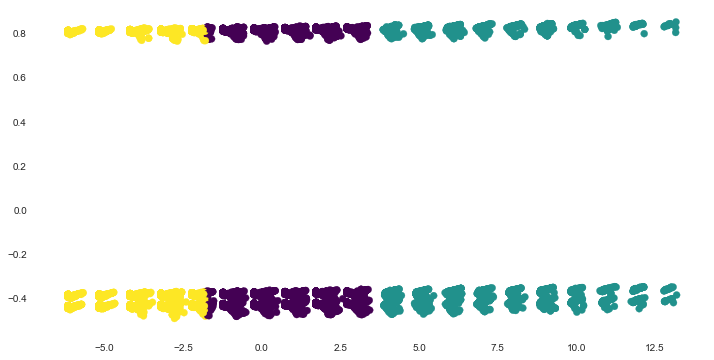

0 6


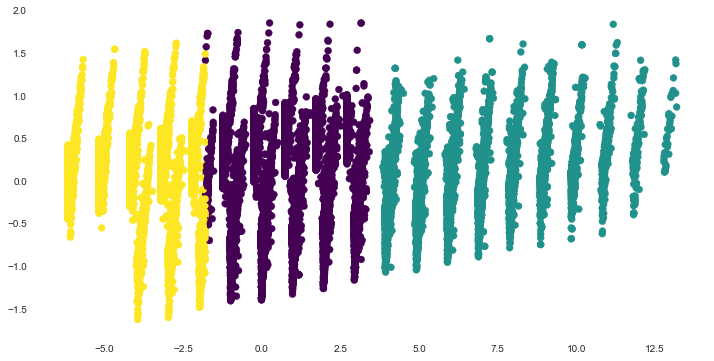

1 2


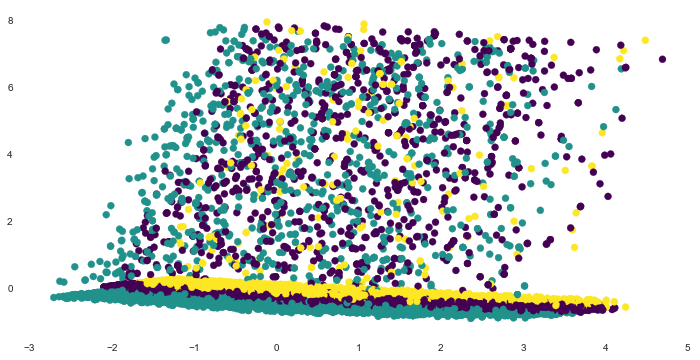

1 3


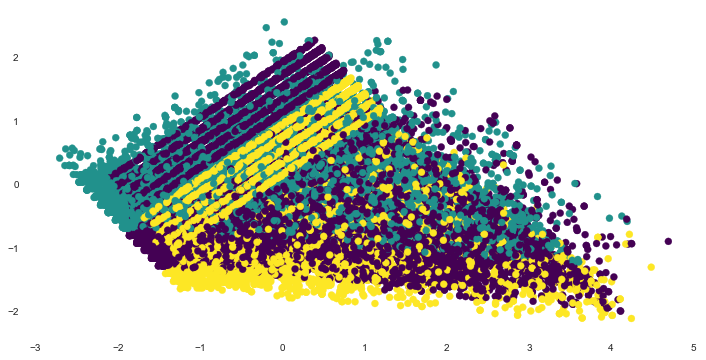

1 4


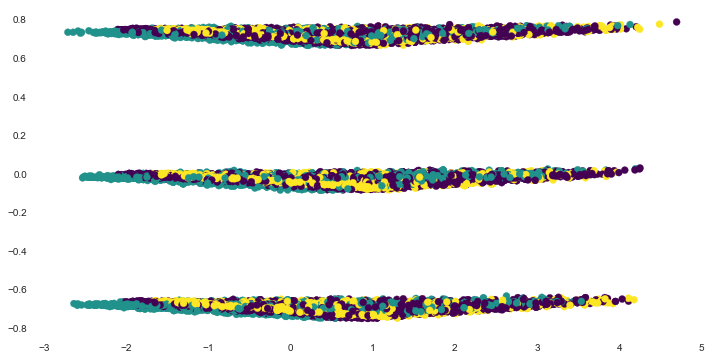

1 5


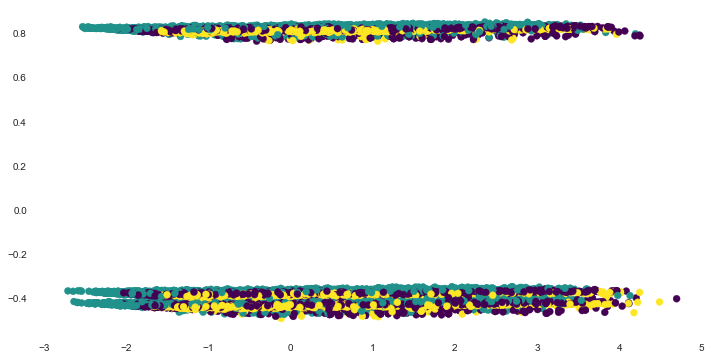

1 6


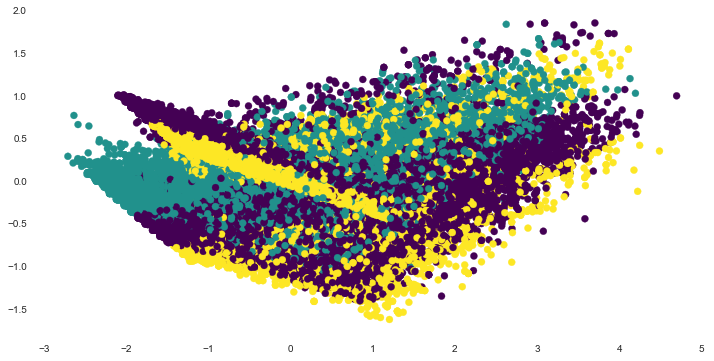

2 3


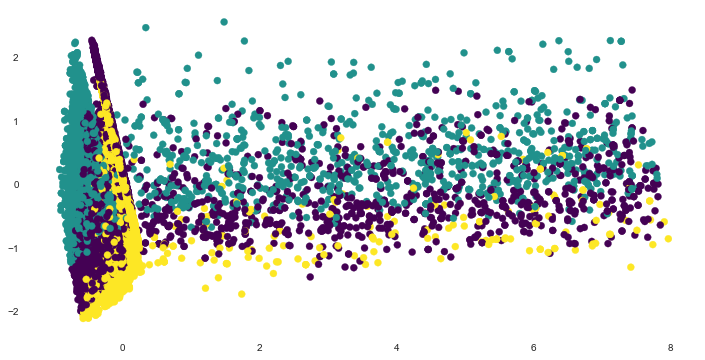

2 4


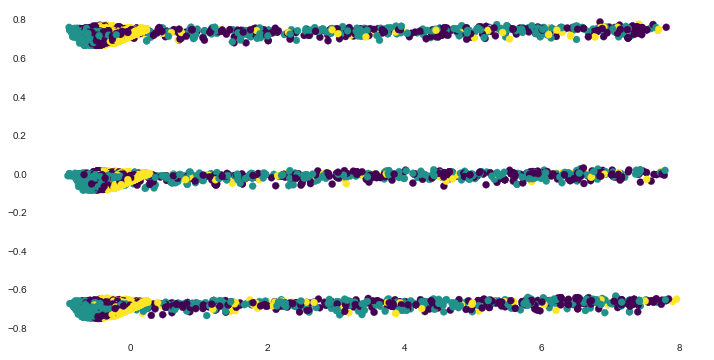

2 5


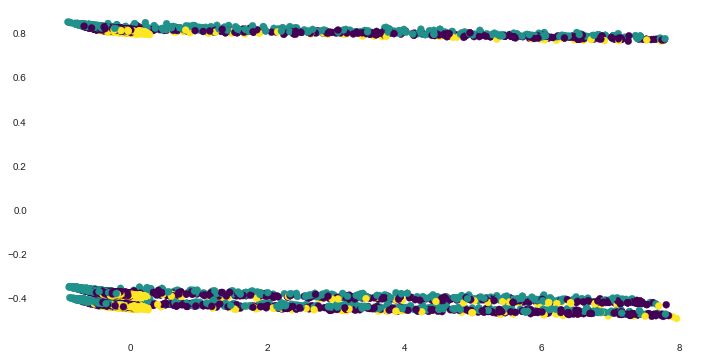

2 6


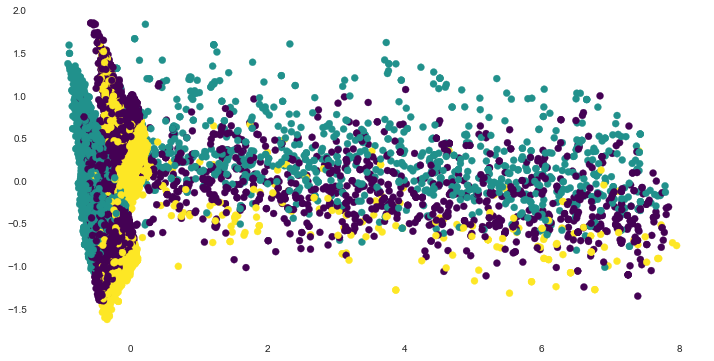

3 4


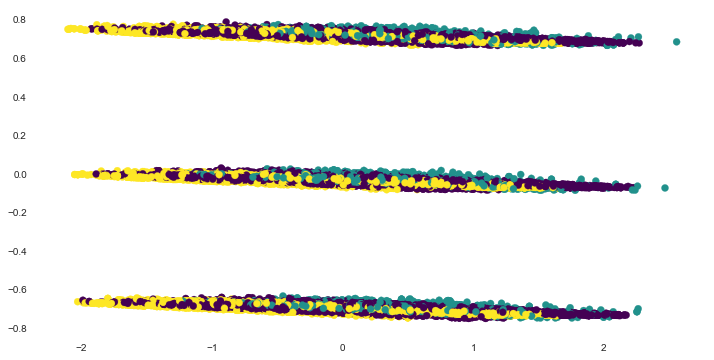

3 5


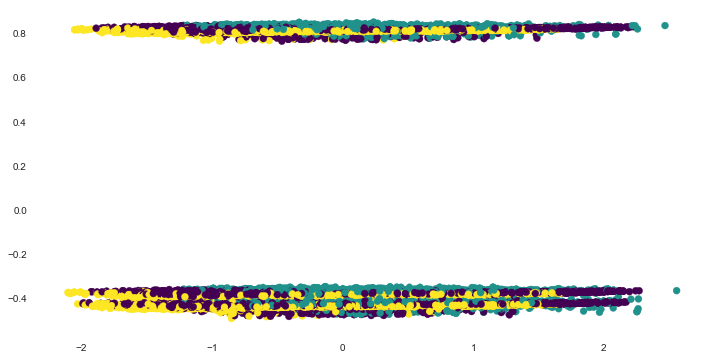

3 6


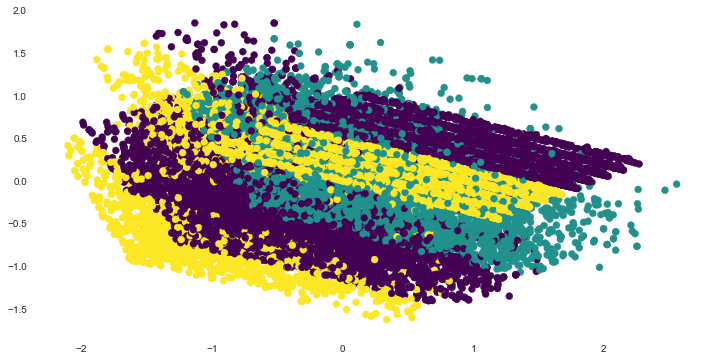

4 5


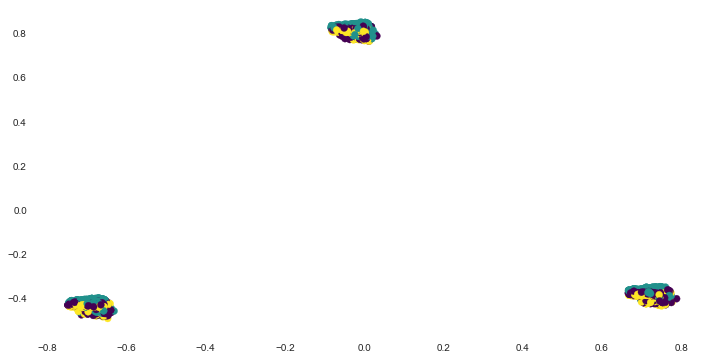

4 6


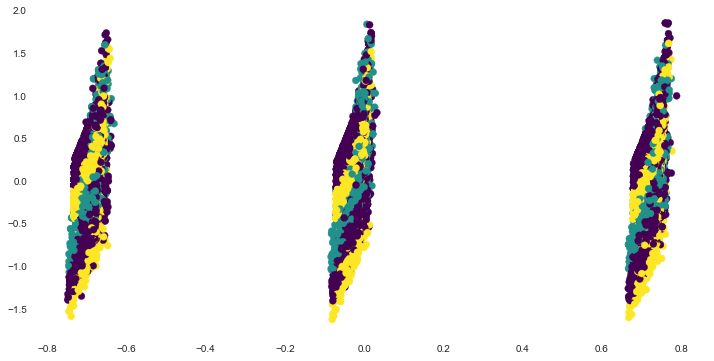

5 6


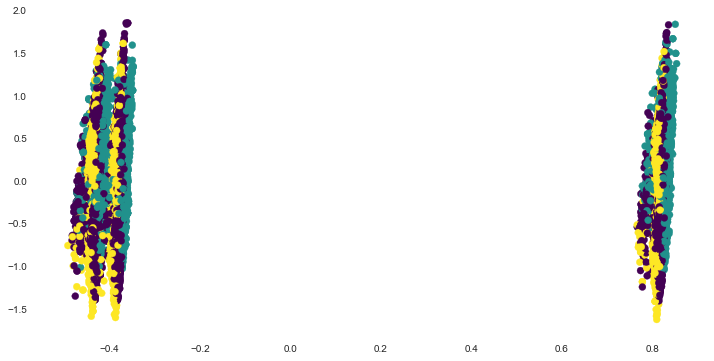

In [16]:

clusters = 3
kmeans = KMeans(n_clusters = clusters, random_state = 0).fit(pca_x)
y_kmeans = kmeans.fit_predict(pca_x)

# plot all clusters
for x in range(components):
    for y in range(x + 1, components):
        print(x, y)
        plt.scatter(pca_x[:, x], pca_x[:, y], c=y_kmeans, cmap='viridis')
        plt.show()

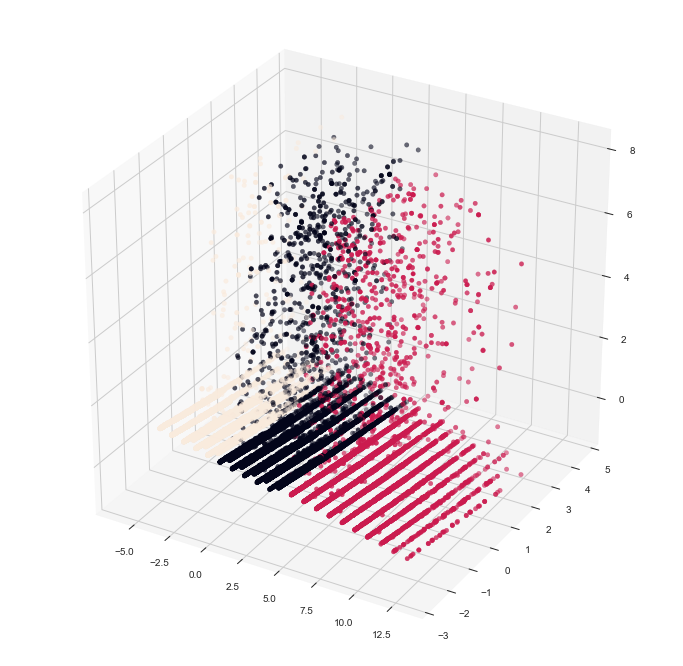

In [17]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_x[:, 0], pca_x[:, 1], pca_x[:, 2], c=y_kmeans)